## M3Drop for feature selection
* Try the tool published in [M3Drop: dropout-based feature selection for scRNASeq](10.1093/bioinformatics/bty1044)
* The tool hasa different function for UMI based protocols (e.g. 10x) and full-transcript protocols


In [1]:
library(Seurat)
library(M3Drop)
library(dplyr)
sessionInfo()

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3

Loading required package: numDeriv


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 14.04.6 LTS

Matrix products: default
BLAS/LAPACK: /path/to/envs/seuratV3/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] dplyr_0.8.3         M3Drop_1.10.0       numDeriv_2016.8-1.1
[4] Seurat_3.0.2       

loaded via a namespace (and not attached):
  [1] nlme_3.1-141        tsne_0.1-3          matrixStats_0.54.0 
  [4] bitops_1.0-6        RColorBrewer_1.1-2  httr_1.4.1         
  [7] repr_0.19.2         backports_1.1.4     sct

## Load data

In [2]:
pbmc.data <- Read10X(data.dir = "/path/to/data/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features)

### Standard pre-processing workflow

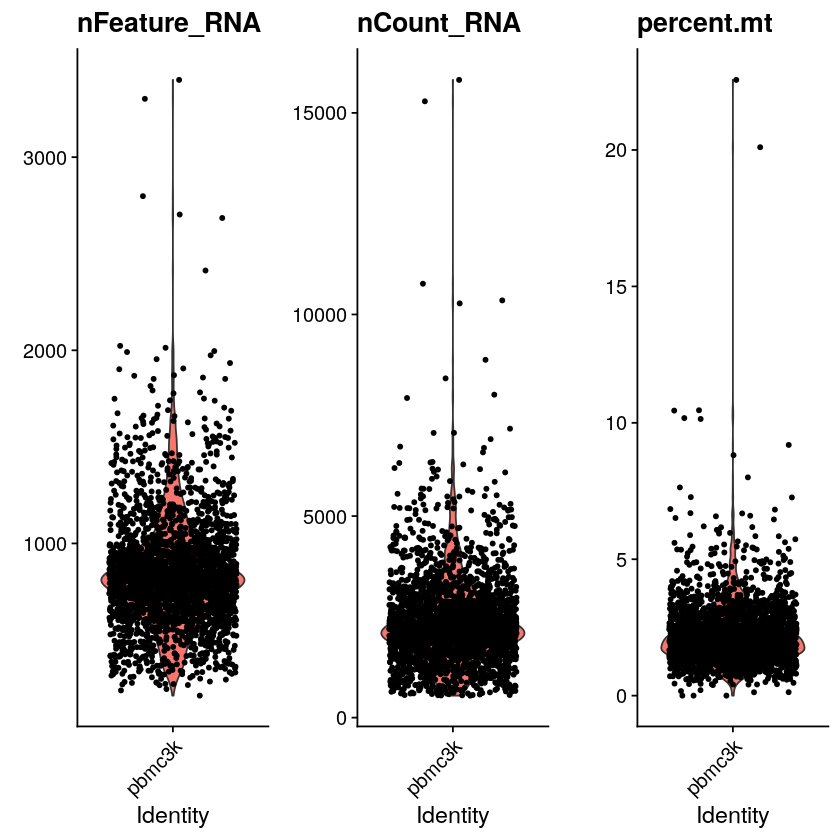

In [3]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

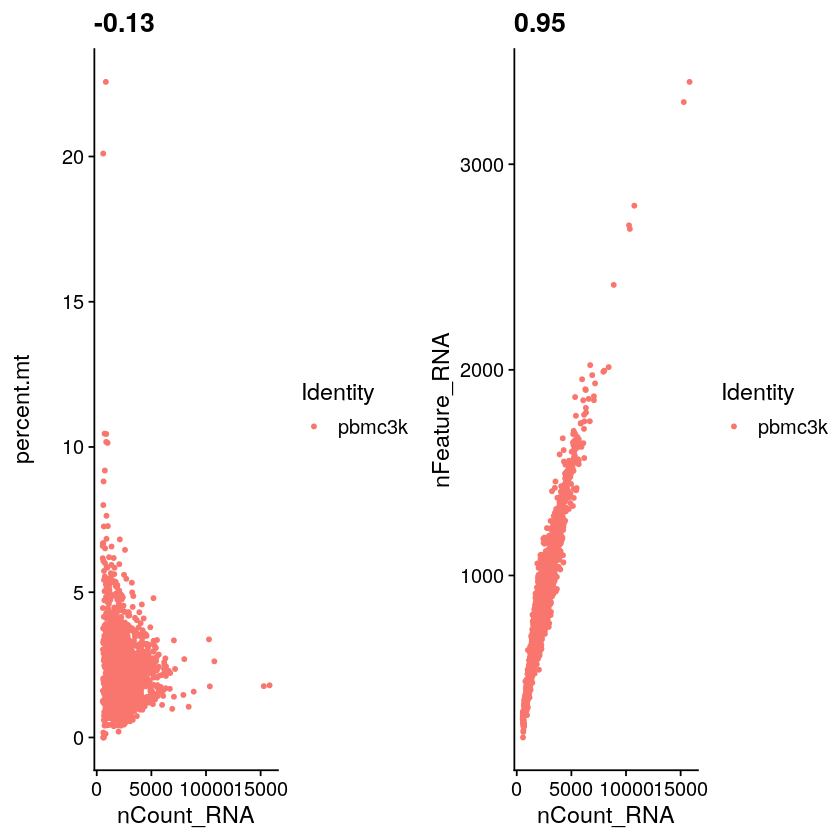

In [4]:
# FeatureScatter is typically used to visualize feature-feature relationships, but can be used
# for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
CombinePlots(plots = list(plot1, plot2))

## Remove outliers
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

In [5]:
pbmc


An object of class Seurat 
13714 features across 2638 samples within 1 assay 
Active assay: RNA (13714 features)

## NBumi
* a depth-adjusted negative binomial model (DANB)
* Functions relating to the DANB model are tagged with the ”NBumi” prefix

In [6]:
count.matrix <- GetAssayData(object = pbmc, slot = "counts")

## Load data from raw count matrix 
count_mat <- NBumiConvertData(count.matrix, is.log = FALSE, is.counts = TRUE)

[1] "Removing  1 undetected genes."


* Fit the DANB model to this count matrix, and check it fits the data

In [7]:
DANB_fit <- NBumiFitModel(count_mat)


### Fit the DANB model to our data

[1] 42088109 23744846


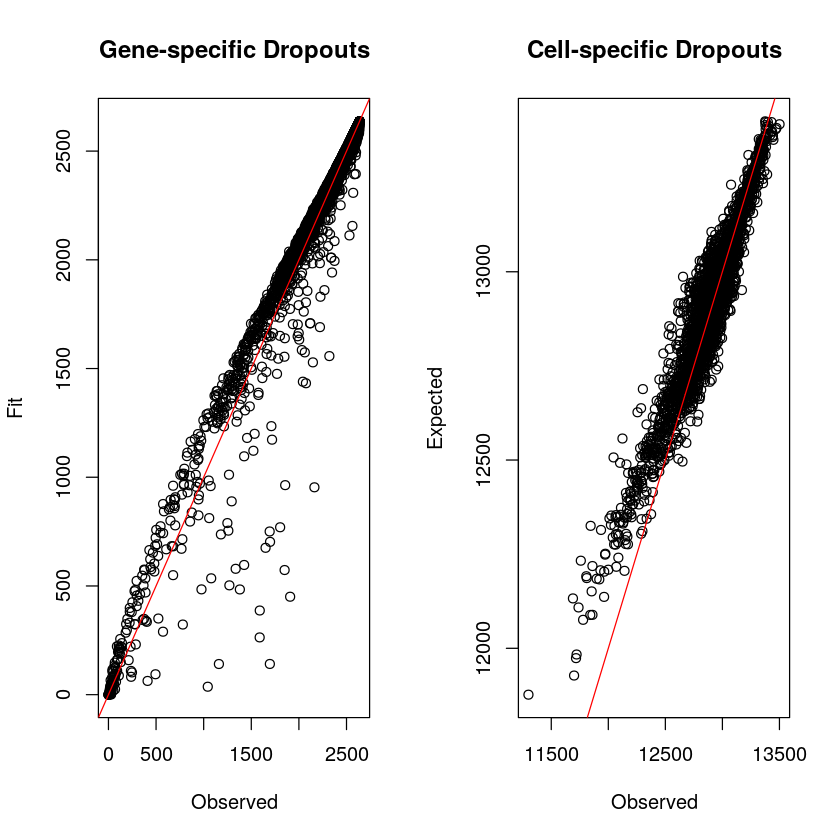

In [8]:
par(mfrow=c(1,2))
stats <- NBumiCheckFitFS(count_mat, DANB_fit)
print(c(stats$gene_error,stats$cell_error))

* Data (observed) fits well what is expected by the model

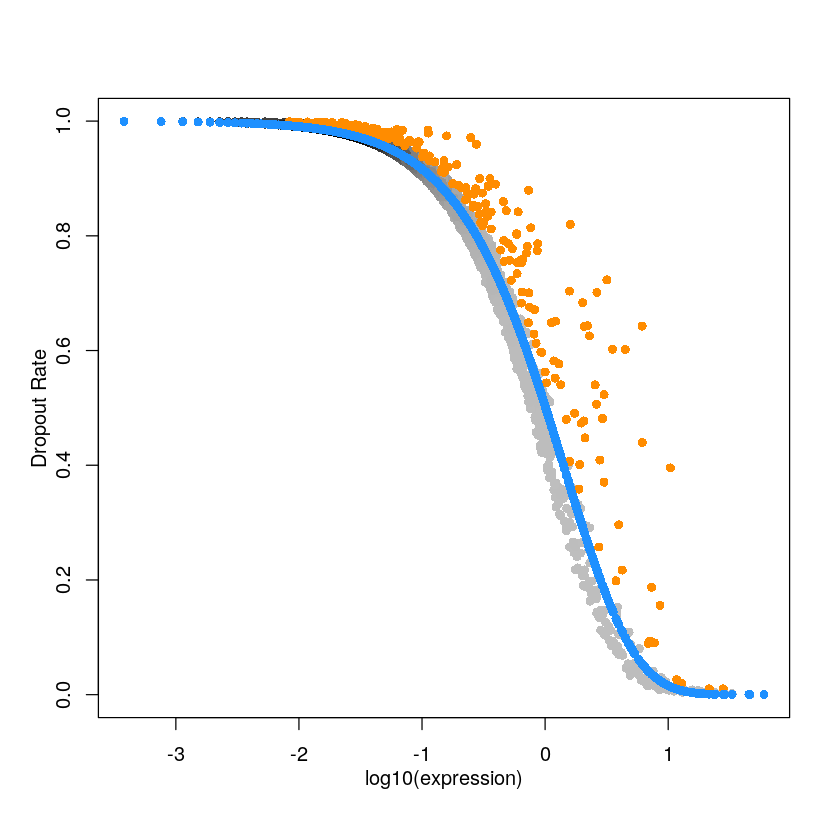

In [9]:
NBDropFS <- NBumiFeatureSelectionCombinedDrop(DANB_fit, method="fdr", qval.thres=0.05, suppress.plot=FALSE)

In the above plot:
* Each point a gene
* colored by local density of point arounf it (black => high density)
* Blue line the fitted relationship between mean and dropout rate
* Orange point significant features

In [13]:
head(NBDropFS)

,Gene,effect_size,p.value,q.value
S100A9,S100A9,0.5889847,0,0
S100A8,S100A8,0.5525044,0,0
CST3,CST3,0.5021414,0,0
NKG7,NKG7,0.4839724,0,0
GNLY,GNLY,0.4583880,0,0
TYROBP,TYROBP,0.4556170,0,0


In [17]:
selectedGenes <- NBDropFS$Gene
length(selectedGenes)


[1] 227

### Resume with the rest of the Seurat workflow

In [21]:
## Normalizing the data
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

## Scaling the data
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



In [22]:
## Identify high variable features
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

In [23]:
## Overlap the set of genes from NBDROP with the 2000 most variable genes
length(which(selectedGenes %in%  VariableFeatures(object = pbmc)))

[1] 189

In [24]:
## Perform linear dimensional reduction
pbmc <- RunPCA(pbmc, features = selectedGenes)

PC_ 1 
Positive:  CDA, ISG15, AGTRAP, EFHD2, HES4, TNFRSF1B, RBP7, PGD, NADK, C1QA 
	   ENO1, SDHB, GNB1, VAMP3, CTNNBIP1, TNFRSF8, RER1, PINK1, FBXO6, CAPZB 
	   C1QB, PARK7, MIIP, PLOD1, C1orf86, ARHGEF10L, PLEKHM2, MRPL20, AURKAIP1, KCNAB2 
Negative:  RPL22, TNFRSF4, ID3, TNFRSF25, TCEA3, MDS2, HNRNPR, UBIAD1, TNFRSF18, FBXO44 
	   AGMAT, RP4-758J18.2, TARDBP, MIB2, TP73-AS1, GLTPD1, HP1BP3, DHRS3, RP11-108M9.6, EXOSC10 
	   SLC35E2B, CROCCP2, APITD1, PRKCZ, MRTO4, ARHGEF19, UBE2J2, ATP13A2, FBXO2, SLC35E2 
PC_ 2 
Positive:  TNFRSF18, ENO1, SDF4, CAPZB, MIB2, CDC42, TNFRSF4, FBXO6, HNRNPR, DDOST 
	   PARK7, MINOS1, TNFRSF25, MAD2L2, THAP3, SRM, PANK4, TNFRSF14, CPSF3L, RER1 
	   ACOT7, SPEN, CCNL2, UBE2J2, ACAP3, EFHD2, DNAJC11, KCNAB2, MRPL20, MMP23B 
Negative:  RBP7, CDA, PGD, AGTRAP, PADI4, UBR4, CDK11B, CDK11A, RP11-169K16.9, PIK3CD 
	   EXOSC10, ARHGEF10L, VPS13D, DDI2, KIAA2013, CEP104, SMIM1, H6PD, PLEKHM2, CTNNBIP1 
	   CAMTA1, RP11-108M9.4, TP73-AS1, AGRN, OTUD3, DFFB, E2F2

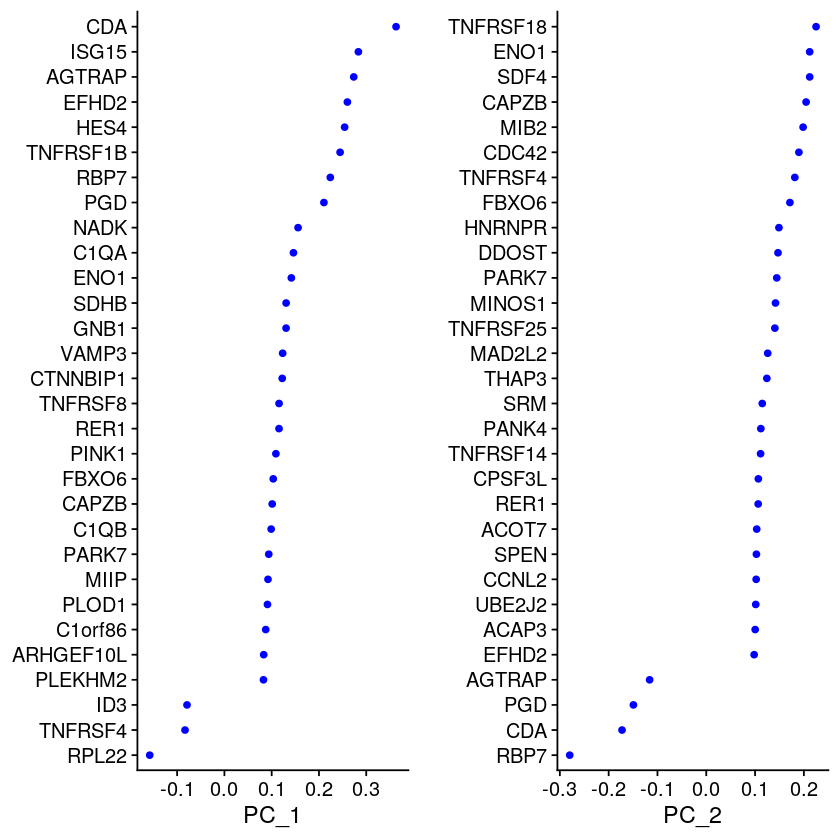

In [25]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

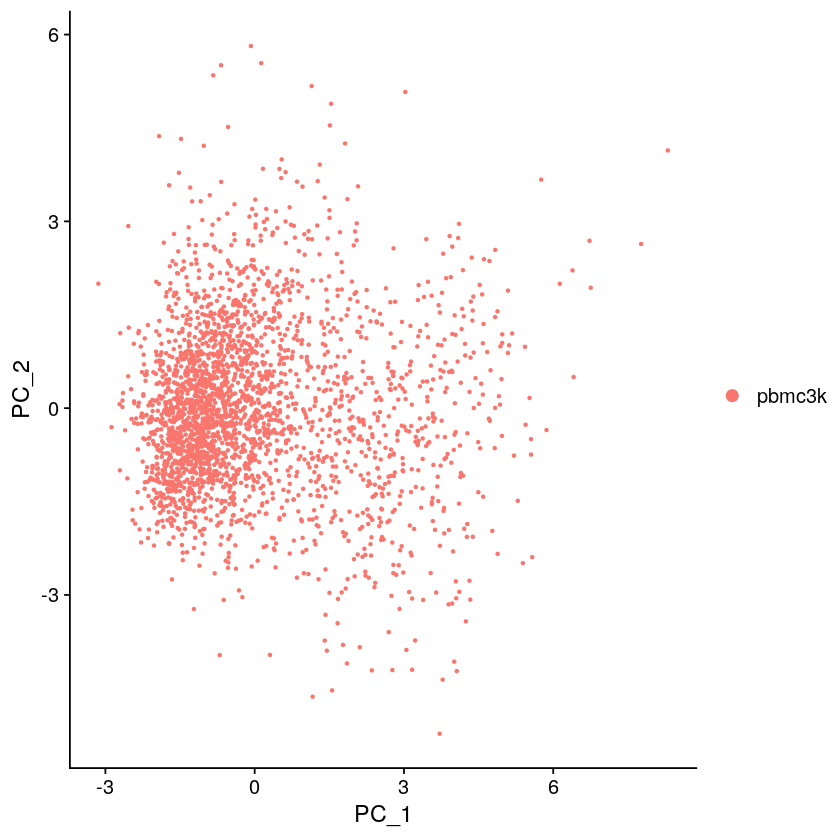

In [26]:
DimPlot(pbmc, reduction = "pca")

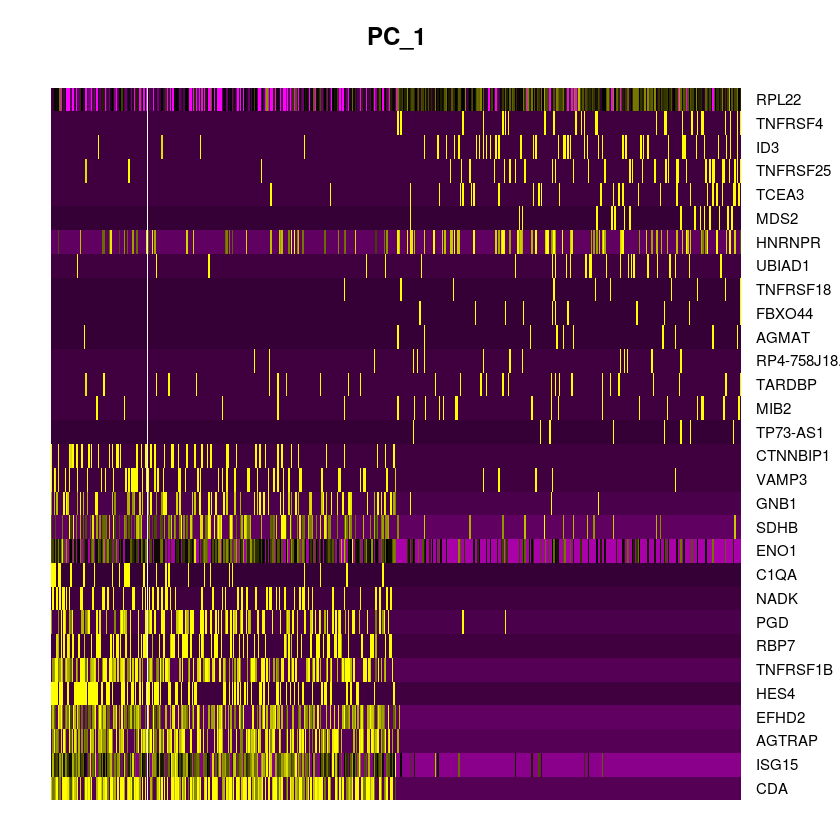

In [27]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

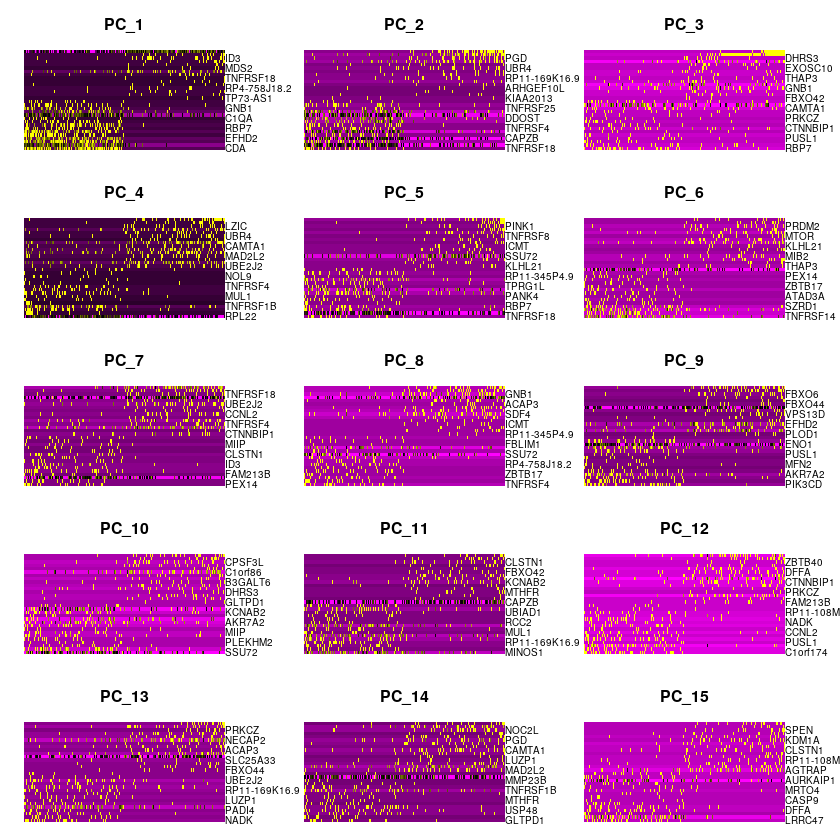

In [28]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

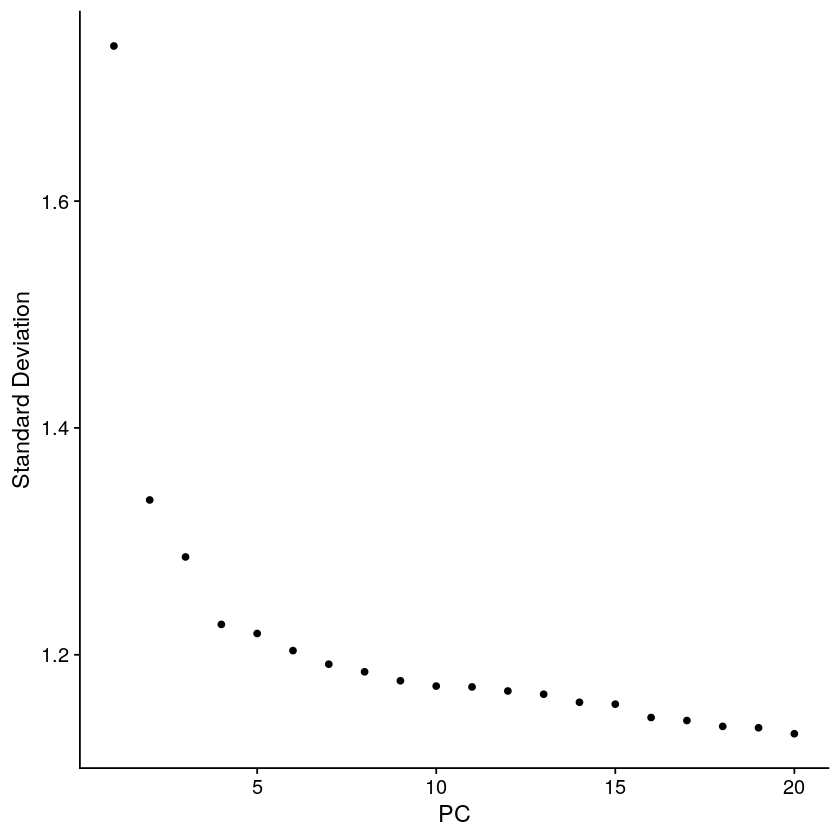

In [29]:
ElbowPlot(pbmc)

In [30]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 86993

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7169
Number of communities: 4
Elapsed time: 0 seconds


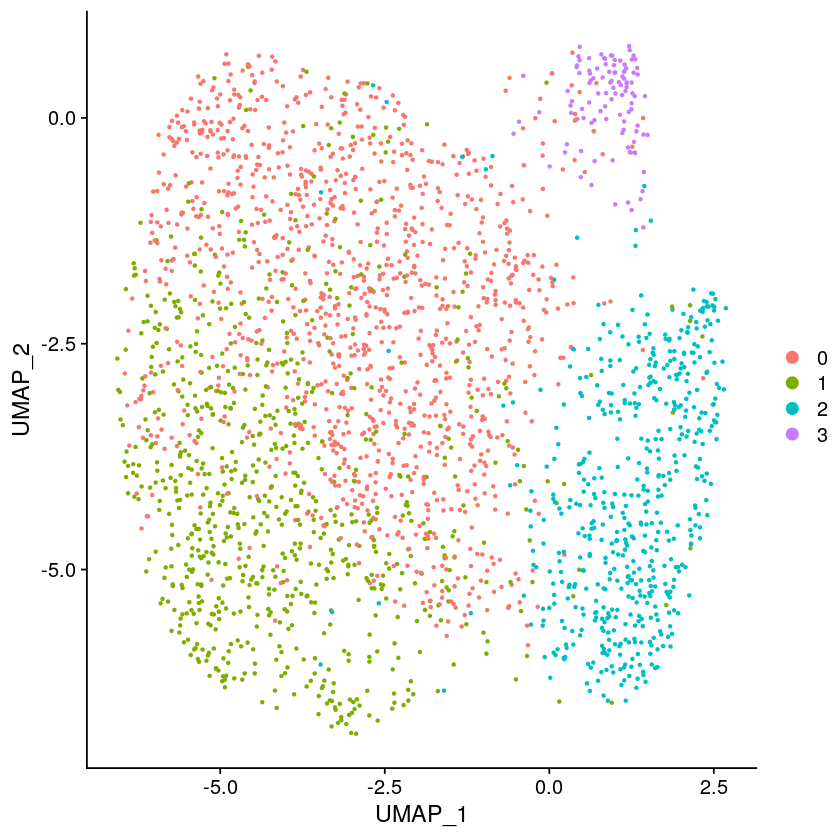

In [31]:
pbmc <- RunUMAP(pbmc, dims = 1:10)
DimPlot(pbmc, reduction = "umap")

Results do not fit the expected and are worse than the standard Seurat workflow
* Repeat by selecting the top 2000 genes with this methodology

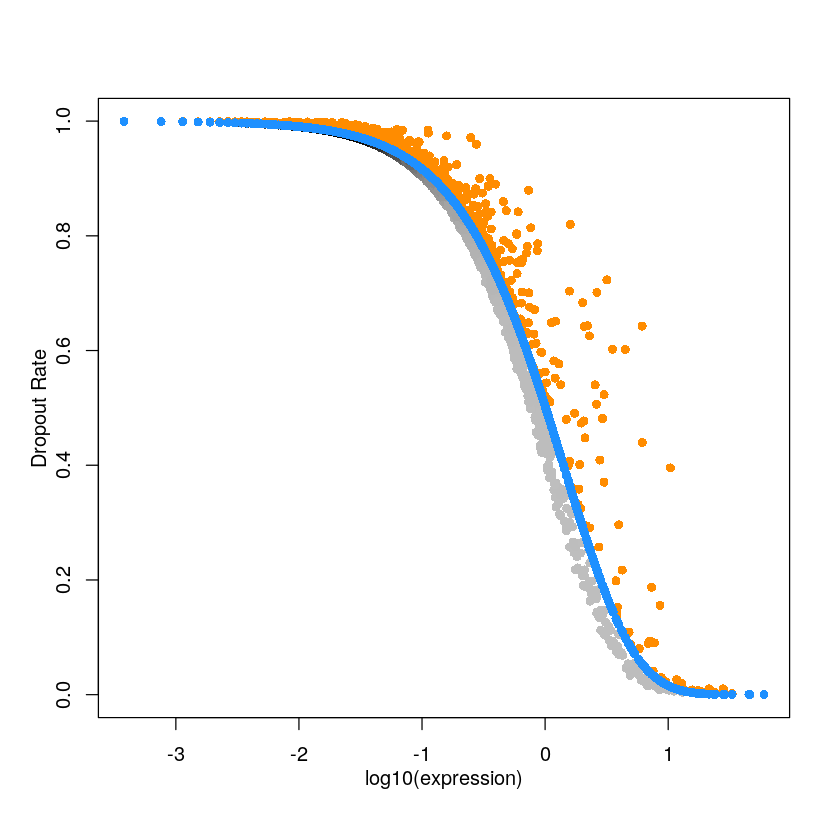

In [34]:
NBDropFS_top <- NBumiFeatureSelectionCombinedDrop(DANB_fit, ntop = 2000, suppress.plot=FALSE)

In [38]:
selectedGenes_top <- NBDropFS_top$Gene
length(selectedGenes_top)

[1] 2000

In [39]:
## Overlap the set of genes 
length(which(selectedGenes_top %in%  VariableFeatures(object = pbmc)))

[1] 1472

In [40]:
pbmc <- RunPCA(pbmc, features = selectedGenes_top)

PC_ 1 
Positive:  RPS27A, RPS27, RPL31, RPL5, CXCR4, RPS8, RPL11, LCK, RPS7, CD2 
	   JUN, RPL22, BIN1, FAIM3, SELL, MAL, ARHGAP15, TRAF3IP3, CD247, CD8B 
	   CMPK1, GYPC, LBH, LDLRAP1, TSTD1, TRABD2A, MZT2A, MGAT4A, SH3YL1, AAK1 
Negative:  FCER1G, S100A9, S100A8, CTSS, S100A11, S100A6, NCF2, S100A4, CDA, FGR 
	   MNDA, RGS2, IFI6, C1orf162, SH3BGRL3, CSF3R, ATP6V0B, FCGR2A, ISG15, AGTRAP 
	   S100A10, RBP7, CAPG, RHOB, MTMR11, EFHD2, HES4, FCGR3A, H3F3A, FCGR1A 
PC_ 2 
Positive:  GNLY, FCGR3A, CD247, XCL2, RHOC, CD53, XCL1, SH2D1B, FCRL6, C1orf21 
	   ID2, YWHAQ, CAP1, FASLG, PLEK, ZAP70, CD160, ACTR3, SH2D2A, ENO1 
	   CAPZB, LCK, SLAMF7, SH3BGRL3, FBXO6, EFHD2, RASSF5, PDIA6, TPM3, PTPRC 
Negative:  S100A8, S100A9, RPL11, RBP7, S100A12, CSF3R, RPS27, QPCT, FCGR1A, CDA 
	   IL1B, RPS8, CTSS, PGD, FCRLA, CAPG, G0S2, FCRL1, NCF2, MNDA 
	   AFF3, FCGR1B, HNMT, FCGR2B, RPL22, CD1D, IL1RN, RP5-887A10.1, MARC1, KIAA0040 
PC_ 3 
Positive:  RPL11, RPL5, CD52, RPS27, RPL22, RPS7, RPS8, RPL31

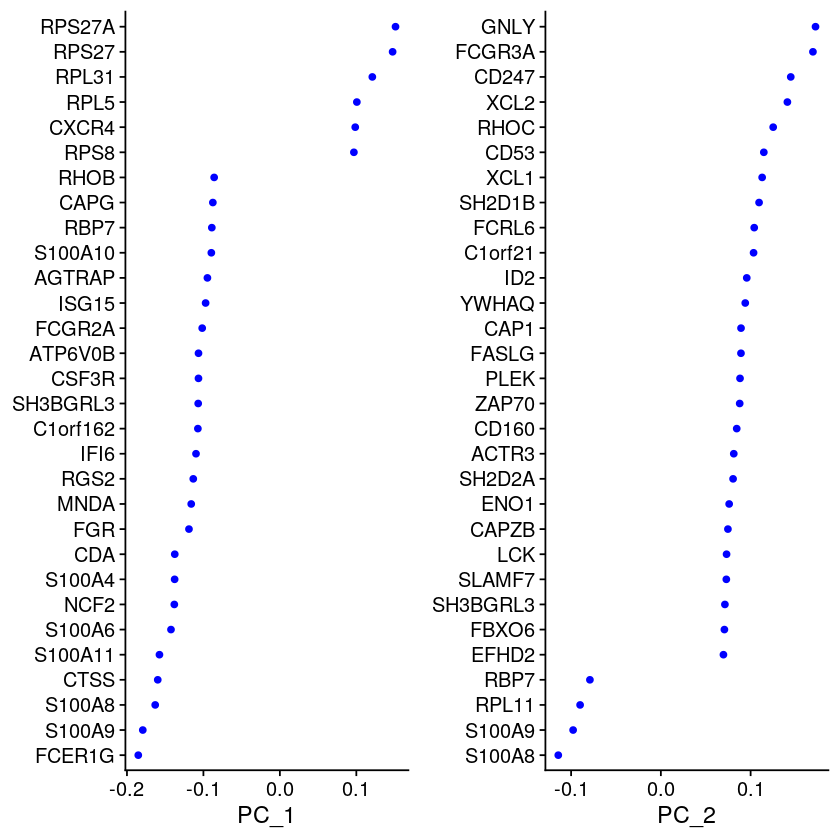

In [41]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

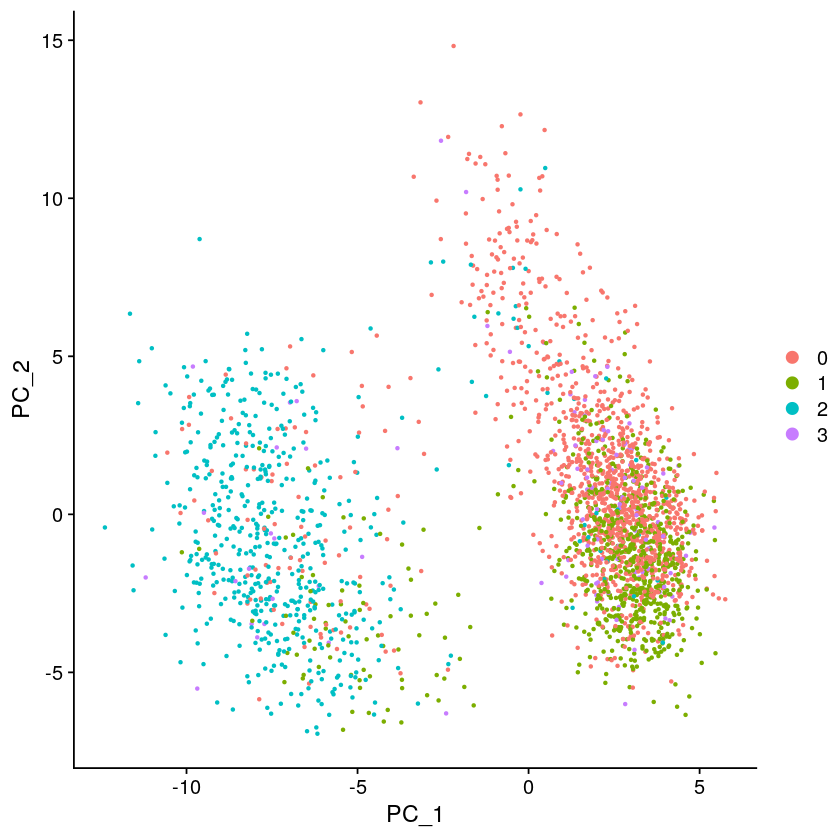

In [42]:
DimPlot(pbmc, reduction = "pca")

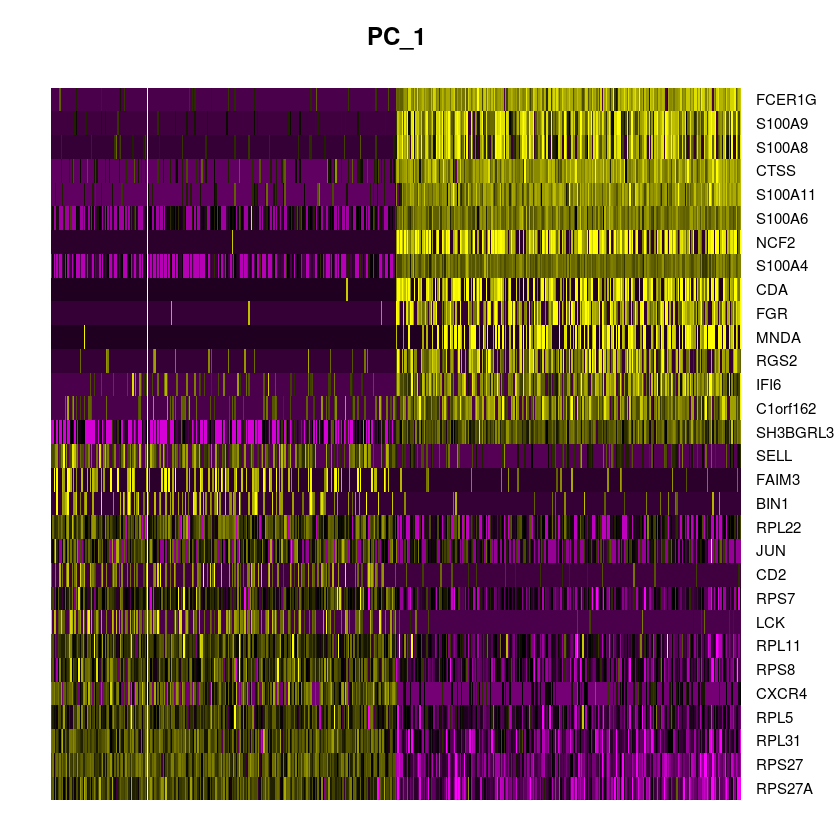

In [43]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

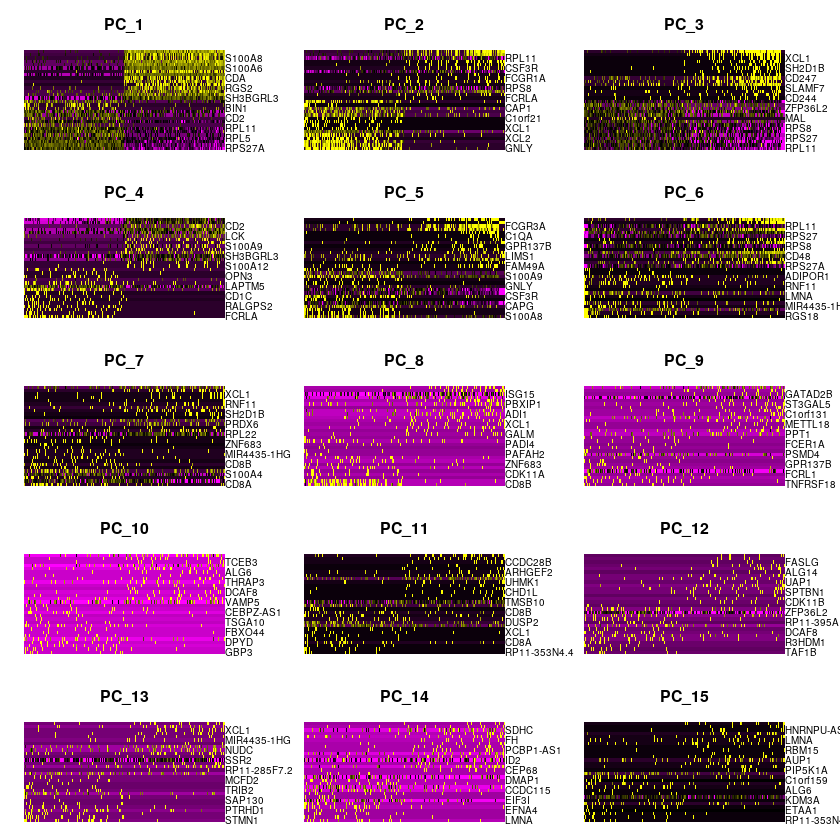

In [44]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

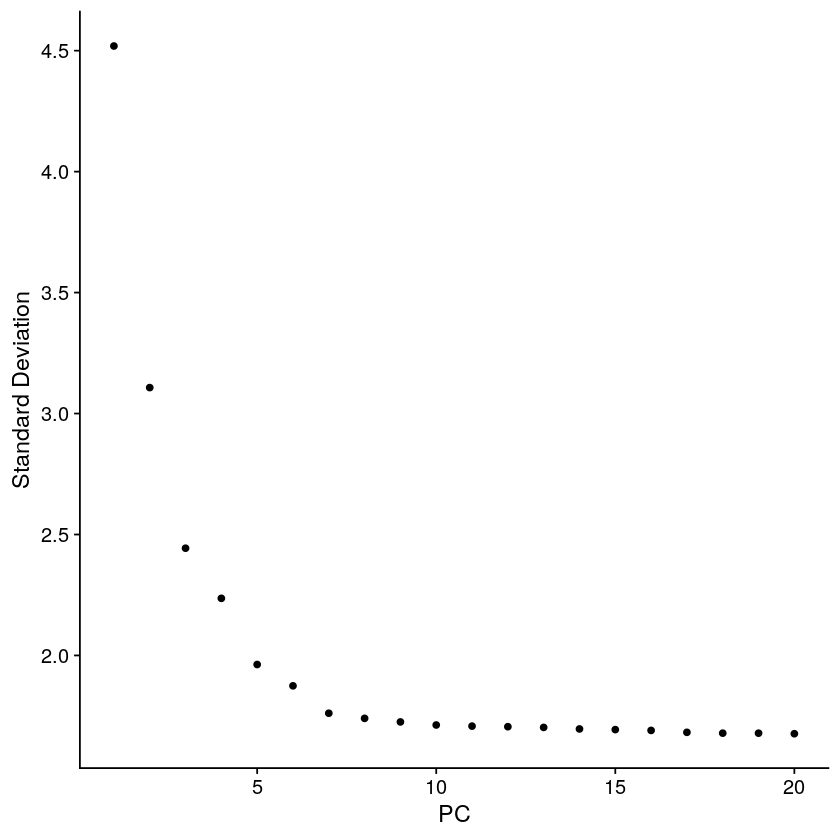

In [45]:
ElbowPlot(pbmc)

In [48]:
pbmc <- FindNeighbors(pbmc, dims = 1:7)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 88520

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8419
Number of communities: 8
Elapsed time: 0 seconds


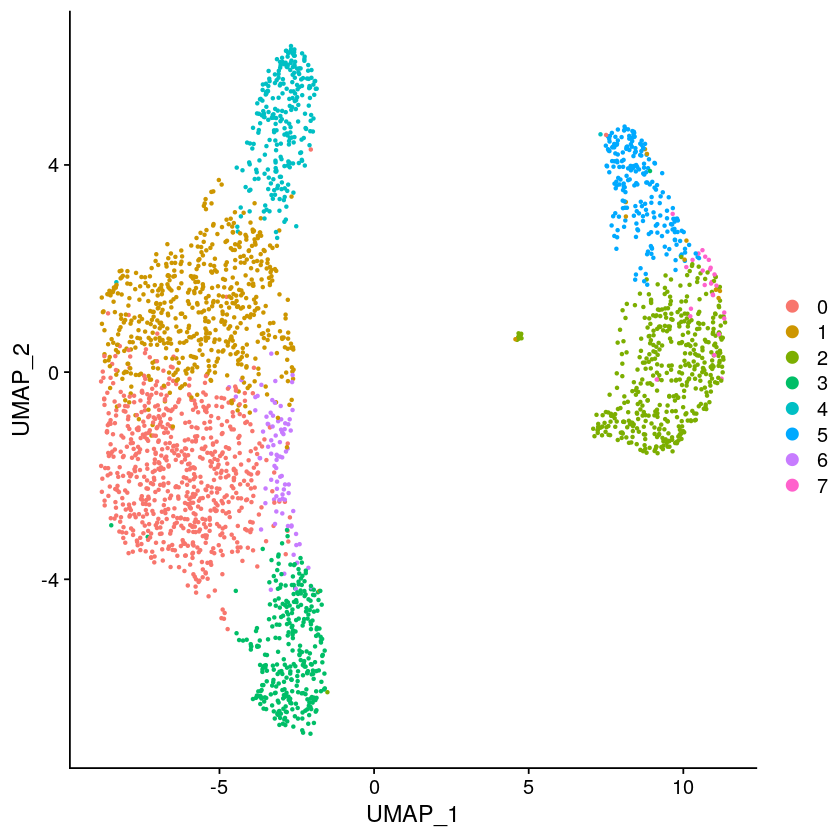

In [50]:
pbmc <- RunUMAP(pbmc, dims = 1:7)
DimPlot(pbmc, reduction = "umap")

The above clasification is also worse than the standard Seurat workflow
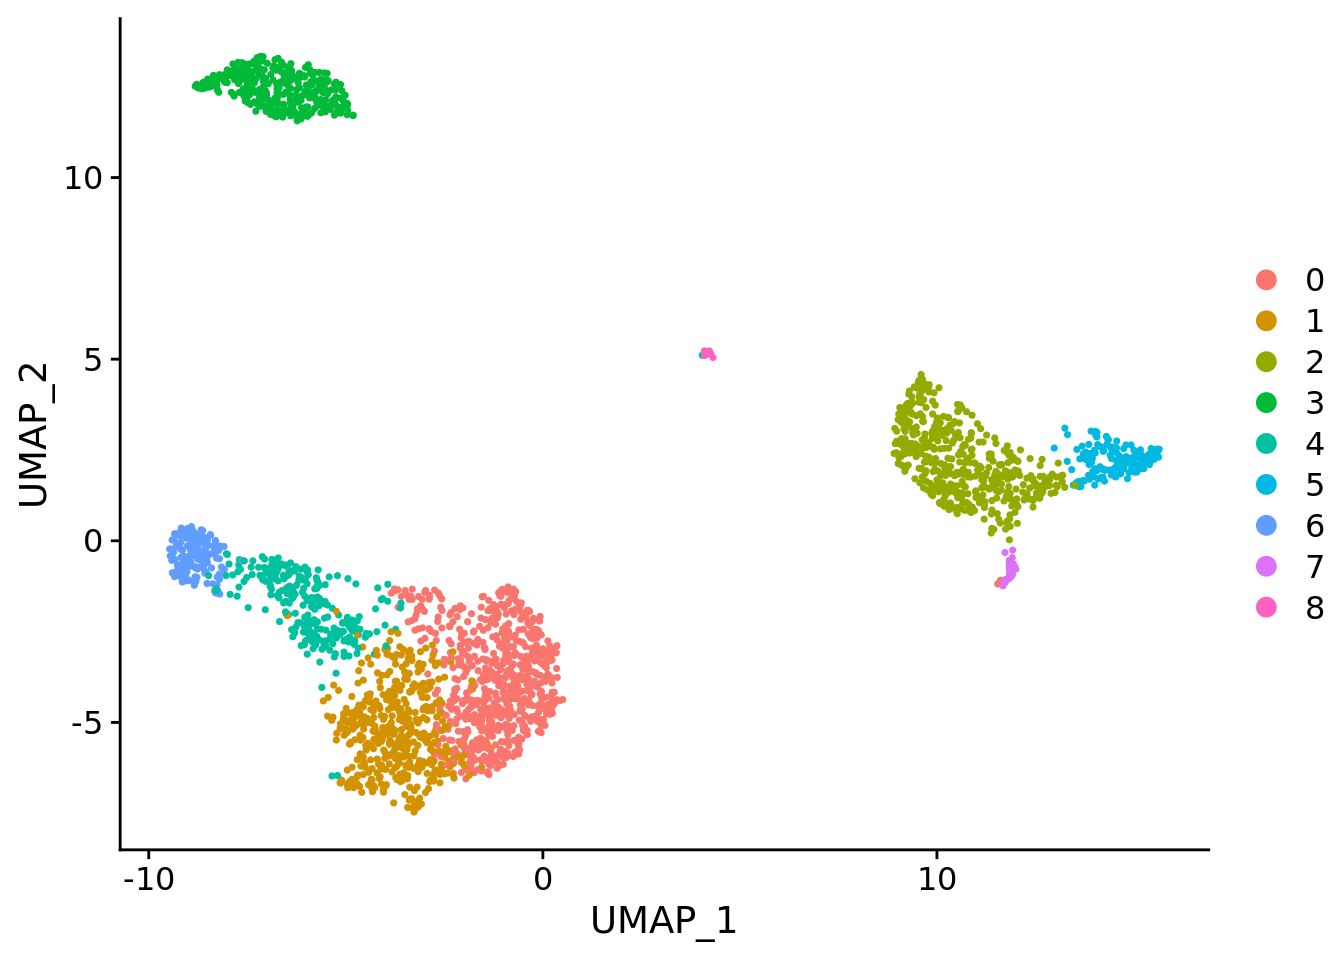

In [ ]:
### Try on Smart-seq data with the 